In [13]:
cd \\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs  

\\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs


In [14]:
ls

 Volume in drive Z is 4tb v3
 Volume Serial Number is 7E54-BBD3

 Directory of Z:\ephys_recordings\092820\J524RT\outputs

10/01/2020  10:38 AM    <DIR>          .
10/01/2020  10:38 AM    <DIR>          ..
09/30/2020  11:12 AM        25,348,348 092820_J524RT_checkerboard_hf_REYE.avi
09/30/2020  11:11 AM        58,334,637 092820_J524RT_checkerboard_hf_TOP1.nc
09/30/2020  11:13 AM       124,193,315 092820_J524RT_checkerboard_hfReye.nc
09/30/2020  11:14 AM       201,216,848 092820_J524RT_checkerboard_hfworld.nc
09/30/2020  05:15 PM         3,706,140 092820_J524RT_fm1_ephys.nc
09/30/2020  05:24 PM       563,461,730 092820_J524RT_fm1_REYE_plot.avi
10/01/2020  10:38 AM            43,574 092820_J524RT_fm1_TOP1_nose_trace.png
09/30/2020  05:43 PM     1,962,888,569 092820_J524RT_fm1Reye.nc
09/30/2020  06:12 PM     1,486,099,820 092820_J524RT_fm1world.nc
09/30/2020  06:12 PM        31,427,090 092820_J524RT_ir_led_hf_REYE_plot.avi
09/30/2020  06:13 PM       143,201,050 092820_J524RT_ir_led_hfReye.

In [43]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'

In [16]:
world_data = xr.open_dataset("092820_J524RT_fm1world.nc")
world_data


<xarray.Dataset>
Dimensions:      (frame: 60978, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 ... 60973 60974 60975 60976 60977
    timestamps   (frame) timedelta64[ns] ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8 ...

In [17]:
world_vid = np.uint8(world_data['WORLD_video'])
world_vid

array([[[ 24, 143, 108, ..., 125, 128, 128],
        [ 24, 143, 108, ..., 125, 128, 128],
        [ 24, 143, 108, ..., 125, 128, 128],
        ...,
        [ 16, 129, 110, ...,  92,  94,  95],
        [ 19, 128, 110, ...,  90,  90,  92],
        [ 20, 127, 110, ...,  89,  90,  90]],

       [[ 21, 181, 106, ..., 109, 108, 107],
        [ 20, 181, 106, ..., 109, 108, 107],
        [ 20, 178, 103, ..., 109, 108, 107],
        ...,
        [ 19, 160,  95, ..., 106, 104, 106],
        [ 20, 160,  95, ..., 104, 104, 104],
        [ 20, 160,  95, ..., 103, 104, 104]],

       [[ 24, 173, 107, ...,  94, 101, 103],
        [ 23, 173, 107, ...,  97, 100,  98],
        [ 23, 170, 104, ..., 101,  97,  96],
        ...,
        [ 14, 164,  87, ..., 108, 108, 108],
        [ 14, 164,  87, ..., 109, 109, 109],
        [ 14, 164,  87, ..., 108, 108, 108]],

       ...,

       [[ 20, 146,  87, ..., 100, 100, 101],
        [ 20, 146,  87, ..., 100, 100, 101],
        [ 20, 146,  87, ..., 100, 100, 101

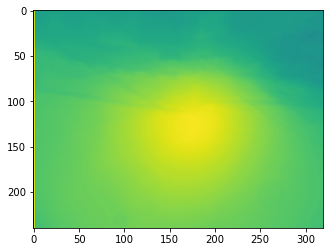

In [18]:
plt.imshow(np.mean(np.uint8(world_vid),axis=0))

In [19]:
#ephys_data = xr.open_dataset('092820_J524RT_fm1_ephys.nc')
#ephys_data


In [20]:
eye_data = xr.open_dataset("092820_J524RT_fm1Reye.nc")
eye_data

<xarray.Dataset>
Dimensions:              (ellipse_params: 6, frame: 64186, height: 240, point_loc: 30, width: 320)
Coordinates:
  * frame                (frame) int64 0 1 2 3 4 ... 64182 64183 64184 64185
  * point_loc            (point_loc) object 'pt1_x' ... 'outer_likelihood'
    timestamps           (frame) timedelta64[ns] ...
  * ellipse_params       (ellipse_params) object 'theta' 'phi' ... 'X0' 'Y0'
Dimensions without coordinates: height, width
Data variables:
    REYE_pts             (frame, point_loc) float64 ...
    REYE_ellipse_params  (frame, ellipse_params) float64 ...
    REYE_video           (frame, height, width) int8 ...

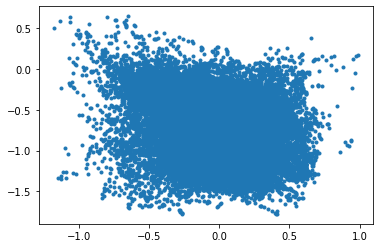

In [21]:
eye_params = eye_data['REYE_ellipse_params']
plt.plot(eye_params.sel(ellipse_params = 'theta'),eye_params.sel(ellipse_params = 'phi'),'.')

In [22]:
eye_t = eye_data.timestamps

<xarray.DataArray 'timestamps' (frame: 64186)>
array([44440412982400000, 44440429206400000, 44440414748800002, ...,
       45633030345600002, 45633046211199999, 45633062435199998],
      dtype='timedelta64[ns]')
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 64181 64182 64183 64184 64185
    timestamps  (frame) timedelta64[ns] 514 days 08:33:32.982400 ... 528 days...

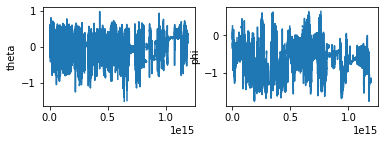

In [23]:
plt.subplot(221)
plt.plot(eye_t-eye_t[0], eye_params.sel(ellipse_params = 'theta')); plt.ylabel('theta')
plt.subplot(222)
plt.plot(eye_t-eye_t[0], eye_params.sel(ellipse_params = 'phi')); plt.ylabel('phi')
eye_t

In [24]:
eye_data.ellipse_params

<xarray.DataArray 'ellipse_params' (ellipse_params: 6)>
array(['theta', 'phi', 'longaxis', 'shortaxis', 'X0', 'Y0'], dtype=object)
Coordinates:
  * ellipse_params  (ellipse_params) object 'theta' 'phi' ... 'X0' 'Y0'

KeyError: "not all values found in index 'ellipse_params'"

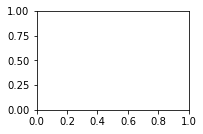

In [25]:
for i,val in enumerate(eye_params[0:4]):
    plt.subplot(2,2,i+1)
    plt.plot(eye_t-eye_t[0],eye_params.sel(ellipse_params = val))
    plt.xlabel(val.values)
    

In [26]:
eye_params

<xarray.DataArray 'REYE_ellipse_params' (frame: 64186, ellipse_params: 6)>
[385116 values with dtype=float64]
Coordinates:
  * frame           (frame) int64 0 1 2 3 4 5 ... 64181 64182 64183 64184 64185
    timestamps      (frame) timedelta64[ns] 514 days 08:33:32.982400 ... 528 ...
  * ellipse_params  (ellipse_params) object 'theta' 'phi' ... 'X0' 'Y0'
Attributes:
    cam_center_x:  260.5774674922246
    cam_center_y:  137.09556400515115

In [27]:
eye_vid = np.uint8(eye_data['REYE_video'])

In [28]:
dEye = np.diff(eye_params.sel(ellipse_params = 'theta'))*180/3.14159

<ipython-input-29-f34f2ec9a132>:19: RuntimeWarning: invalid value encountered in greater
  sacc = np.transpose(np.where(np.abs(dEye)>10))


Text(0.5, 0, 'frame #')

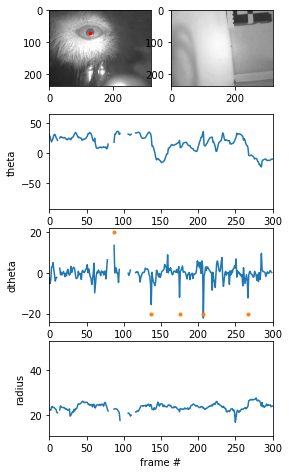

In [29]:
fr = 330
fig = plt.figure(figsize = [4,8])
gs = fig.add_gridspec(4,2)

ax = fig.add_subplot(gs[0,0])
plt.imshow(eye_vid[fr,:,:],'gray')
plt.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')


ax = fig.add_subplot(gs[0,1])
plt.imshow(world_vid[fr,:,:],'gray')

ax = fig.add_subplot(gs[1,:])
ax.plot(eye_params.sel(ellipse_params = 'theta')*180/3.14159)
ax.set_xlim(0,300); ax.set_ylabel('theta')

ax = fig.add_subplot(gs[2,:])
ax.plot(dEye[0:300]); ax.set_ylabel('dtheta')

sacc = np.transpose(np.where(np.abs(dEye)>10))
ax.plot(sacc,np.sign(dEye[sacc])*20,'.')
ax.set_xlim(0,300)

ax = fig.add_subplot(gs[3,:])
ax.plot(eye_params.sel(ellipse_params = 'longaxis'))
ax.set_xlim(0,300); ax.set_ylabel('radius'); ax.set_xlabel('frame #')

In [53]:
writer = FFMpegWriter(fps=60)

<Figure size 216x144 with 0 Axes>

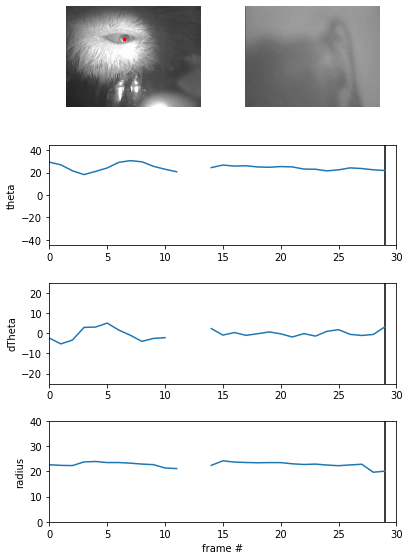

In [76]:
fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(4,2)
axEye = fig.add_subplot(gs[0,0])
axWorld = fig.add_subplot(gs[0,1])
axTheta = fig.add_subplot(gs[1,:])
axdTheta = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[3,:])

frameRange = range(30)
with writer.saving(fig, "writer_test.mp4", 100):
    for fr in frameRange:

        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eye_vid[fr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
        axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
       
        
        axWorld.cla();  axWorld.axis('off'); 
        axWorld.imshow(world_vid[fr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
   
        
        axTheta.cla()
        axTheta.plot(eye_params.sel(ellipse_params = 'theta')[frameRange]*180/3.14159)
        axTheta.set_xlim(frameRange[0],frameRange[-1]+1); axTheta.set_ylabel('theta'); axTheta.set_ylim(-45,45)
        axTheta.vlines(fr,-45,45)

        axdTheta.cla()
        axdTheta.plot(dEye[frameRange]); ax.set_ylabel('dtheta')
       # sacc = np.transpose(np.where(np.abs(dEye[frameRange])>10))
       # axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
        axdTheta.set_xlim(frameRange[0],frameRange[-1]+1); axdTheta.set_ylim(-25,25); axdTheta.set_ylabel('dTheta')
        axdTheta.vlines(fr,-25,25)

        axR.cla()
        axR.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
        axR.set_xlim(frameRange[0],frameRange[-1]+1); axR.set_ylabel('radius'); axR.set_xlabel('frame #')
        axR.set_ylim(0,40)
        axR.vlines(fr,0,40)
        
        plt.tight_layout()
        writer.grab_frame()

In [206]:
plt.hist(np.float(np.diff(eye_data.timestamps)))

TypeError: only size-1 arrays can be converted to Python scalars

In [212]:
eye_data.timestamps.total_seconds()

AttributeError: 'DataArray' object has no attribute 'total_seconds'